# About: Using Selenium

Jupyter NotebookからSeleniumを使ってみる例です。

1. GitHubリポジトリ https://github.com/yacchin1205/jupyter-with-jenkins を開き
2. `conf`ディレクトリの中身を覗く

ことをしてみます。

# 準備

必要なライブラリをインポートします。

In [1]:
import time
import os
from IPython.display import Image

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

WebDriverを準備します。本環境にはChrome Driverのみインストールしています。(Firefoxとか、Pull Requestもらえると嬉しかったり)

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

chrome_options = Options()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--lang=ja')

driver = webdriver.Chrome(options=chrome_options)

スクリーンショットを取得するための一時ディレクトリを準備しておきます。

In [3]:
import tempfile
work_dir = tempfile.mkdtemp()
work_dir

'/tmp/tmp8lphvcb1'

# テストの実施

## ブラウザを開く

WebDriverを使って、URLを指定してブラウザを開きます。

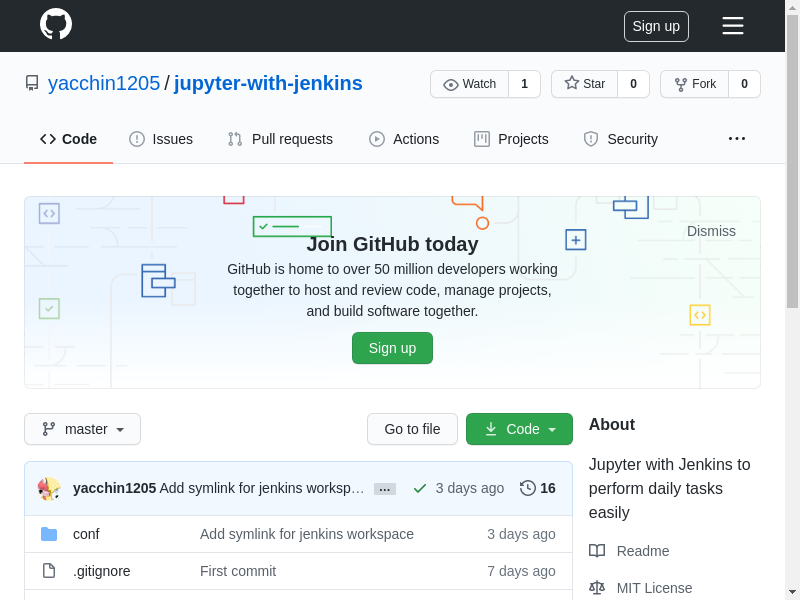

In [4]:
url = 'https://github.com/yacchin1205/jupyter-with-jenkins'
driver.get(url)

# Output the screenshot
driver.save_screenshot(os.path.join(work_dir, 'sample.png'))
Image(os.path.join(work_dir, 'sample.png'))

## 画面遷移の確認

`conf`ディレクトリの中身を覗いてみます。

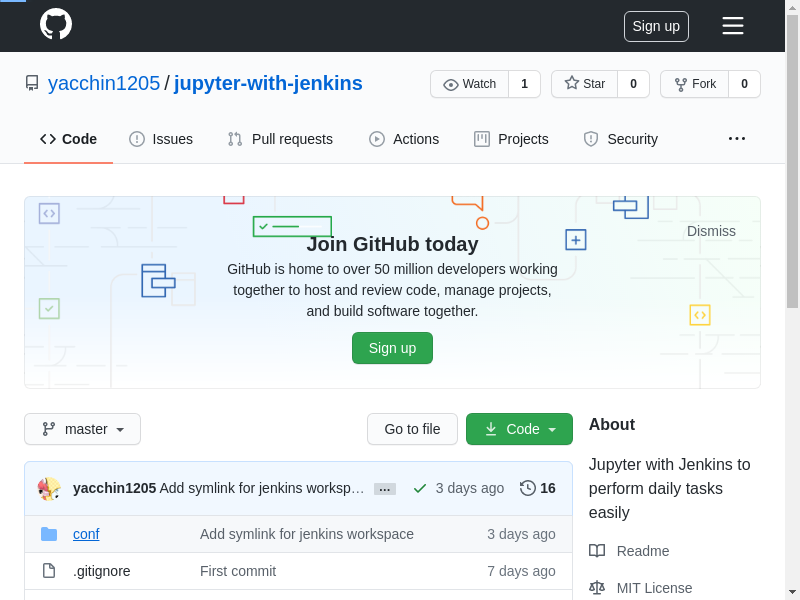

In [5]:
elem = driver.find_element_by_xpath('//a[text() = "conf"]')
elem.click()

driver.save_screenshot(os.path.join(work_dir, 'sample.png'))
Image(os.path.join(work_dir, 'sample.png'))

クリック後即confディレクトリが表示されるわけではないので... `time.sleep`等で適宜待機してから確認するのが良いかもしれません。

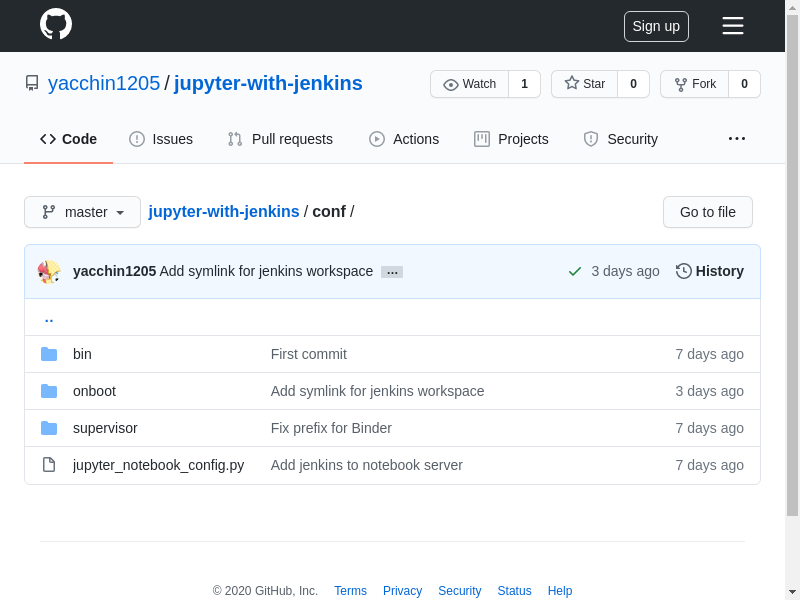

In [6]:
time.sleep(5)

driver.save_screenshot(os.path.join(work_dir, 'sample.png'))
Image(os.path.join(work_dir, 'sample.png'))

## 要素が存在しているかチェック

このように画面遷移をさせながら、適宜予期した要素が存在しているかなど日々チェックできると安心かなと。

以下のコードは期待した要素が存在していないと`NoSuchElementException`で失敗します。

In [7]:
# If the expected file does not exist, it fails with NoSuchElementException
driver.find_element_by_xpath('//a[text() = "jupyter_notebook_config.py"]')

<selenium.webdriver.remote.webelement.WebElement (session="93741041341c38de7b9c3e0bc0139c1f", element="e6e92369-d620-4926-a886-a8d7d4af112f")>

# 後始末

忘れず一時ファイルは削除しておきましょう。

In [8]:
!rm -fr {work_dir}